In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
import jReversion as jR
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import networkx as nx
from statannot import add_stat_annotation
from LDOI import BooleanDOI_DOI as BDOId, BooleanDOI_TargetControl as BDOItc, BooleanDOI_processing as BDOIp

In [2]:
#load data
# network_name_list= [Grieco, TLGLNetwork, bauer, ERBB, fibroblast, saez, BLT, colitis_jijoo, prostate]
# integrated_data = pd.DataFrame()
Model = jR.grieco()
BooleanRuleFileName = '../' + Model['BooleanRule_filename']
NetworkName = Model['network_name']

NumInputs = Model['num_inputs']
NumInputConditions = Model['num_input_conditions']

InputConditions = Model['input_conditions']

OutputNodes = Model['output_nodes']
InputNodes = Model['input_nodes']

# Set parameters
# Note the node name for Gread is the index (integer), one can encode the nodename by adding prefix and suffix
# If the node name from the input file is not this simple, one need to create a dictionary to record the mapping
Prefix, Suffix = 'n', 'n'

TempI = jR.initialize(BooleanRuleFileName, Prefix, Suffix)
Mapping = TempI['mapping']
InverseMapping = TempI['inverse_mapping']
GRead = TempI['Gread']
ReadNodes = TempI['read_nodes']
if Model['reduction_required']:
    GRead = BDOIp.Get_reduced_network(GRead)
    
try:
    GExpanded = nx.read_gml('../networks/' + NetworkName + '_expanded_network.gml')
except IOError:
    GExpanded = BDOIp.Get_expanded_network(GRead, prefix=Prefix, suffix=Suffix)
    nx.write_gml(GExpanded, '../networks/' + NetworkName + '_expanded_network.gml')
   

table_original_network = pd.read_csv('../data/' + NetworkName + '_table_for_original_network.tsv', sep='\t').sort_values(by='node')
GExpanded.remove_edges_from(list(nx.selfloop_edges(GExpanded)))

In [3]:
table_original_network.head()

,node,Class,Canalizing,UnreachableEffective,FFL3,FFL4,FFL5,FFL6,FFL7,FBL
29,AKT,C1,True,True,False,False,False,False,False,0
12,AP1,C1,True,False,False,False,False,False,False,0
6,ATF2,C0,False,False,True,True,True,True,True,0
35,ATM,C0,False,False,False,False,False,False,False,0
31,BCL2,C1,True,True,True,True,True,True,True,0


In [4]:
len(InverseMapping)

106

In [5]:
# FFL
CutOffRange = [3, 4, 5, 6]
FFLTest_INTER = jR.ex_ffl_test_inter(GExpanded, InverseMapping, CutOffRange)
FFLTest_DISC = jR.ex_ffl_test_disc(GExpanded, InverseMapping, CutOffRange)

In [6]:
FFLTest_INTER['AKT'][3]

False

In [7]:
for cut_off in CutOffRange:
    inter = 'RN_' + str(cut_off)
    disc = 'CN_' + str(cut_off)
    table_original_network[inter] = table_original_network.apply(lambda x: np.logical_or(FFLTest_INTER[x['node']][cut_off], FFLTest_INTER['~'+x['node']][cut_off]), axis=1)
    table_original_network[disc] = table_original_network.apply(lambda x: np.logical_and(FFLTest_DISC[x['node']][cut_off], FFLTest_DISC['~'+x['node']][cut_off]), axis=1)

In [8]:
table_original_network = table_original_network.set_index('node')

In [9]:
cut_off_list = CutOffRange
c0 = np.array(table_original_network['Class'].map(lambda x: x == 'C0'), dtype=bool)
c1 = np.array(table_original_network['Class'].map(lambda x: x == 'C1'), dtype=bool)
c2 = np.array(table_original_network['Class'].map(lambda x: x == 'C2'), dtype=bool)
c3 = np.array(table_original_network['Class'].map(lambda x: x == 'C3'), dtype=bool)
real_true = c1
# real_true = np.logical_or(np.array(table_original_network['Class'].map(lambda x: x == 'C0'), dtype=bool), np.array(table_original_network['Class'].map(lambda x: x == 'C1'), dtype=bool))
# accuracy = pd.DataFrame(np.nan, columns=['FFL', 'Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'])
integrated_c0c1c2_accuracy = pd.DataFrame(np.nan, columns=['Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'], index=['RN_'+str(cut_off) for cut_off in cut_off_list])
for cut_off in cut_off_list:
    ffl = 'RN_' + str(cut_off)
    positive = np.array(table_original_network[ffl], dtype=bool)
#     tp = sum(np.logical_and(real_true, positive))
#     fn = sum(np.logical_and(real_true, np.logical_not(positive)))
#     tn = sum(np.logical_and(np.logical_not(real_true), np.logical_not(positive)))
#     fp = sum(np.logical_and(np.logical_not(real_true), positive))
#     pre = float(tp) / (tp + fp)
#     sen = float(tp) / (tp + fn)
#     spe = float(tn) / (tn + fp)
#     acc = (sen + spe) / 2.

    pre = precision_score(np.logical_or(c0, np.logical_or(c1, c2)), positive)
    rec = recall_score(np.logical_or(c0, np.logical_or(c1, c2)), positive) 
    acc = accuracy_score(np.logical_or(c0, np.logical_or(c1, c2)), positive)
    bacc = balanced_accuracy_score(np.logical_or(c0, np.logical_or(c1, c2)), positive)
    f1 = f1_score(np.logical_or(c0, np.logical_or(c1, c2)), positive)
    integrated_c0c1c2_accuracy.loc[ffl]['Precision'] = pre
    integrated_c0c1c2_accuracy.loc[ffl]['Recall'] = rec
    integrated_c0c1c2_accuracy.loc[ffl]['Accuracy'] = acc
    integrated_c0c1c2_accuracy.loc[ffl]['Balanced accuracy'] = bacc
    integrated_c0c1c2_accuracy.loc[ffl]['F1'] = f1
integrated_c0c1c2_accuracy['network'] = NetworkName
integrated_c0c1c2_accuracy.reset_index(inplace=True)

integrated_c3_accuracy = pd.DataFrame(np.nan, columns=['Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'], index=['CN_'+str(cut_off) for cut_off in cut_off_list])
for cut_off in cut_off_list:
    ffl = 'CN_' + str(cut_off)
    positive = np.array(table_original_network[ffl], dtype=bool)
#     tp = sum(np.logical_and(real_true, positive))
#     fn = sum(np.logical_and(real_true, np.logical_not(positive)))
#     tn = sum(np.logical_and(np.logical_not(real_true), np.logical_not(positive)))
#     fp = sum(np.logical_and(np.logical_not(real_true), positive))
#     pre = float(tp) / (tp + fp)
#     sen = float(tp) / (tp + fn)
#     spe = float(tn) / (tn + fp)
#     acc = (sen + spe) / 2.

    pre = precision_score(c3, positive)
    rec = recall_score(c3, positive) 
    acc = accuracy_score(c3, positive)
    bacc = balanced_accuracy_score(c3, positive)
    f1 = f1_score(np.logical_or(c2, c3), positive)
    integrated_c3_accuracy.loc[ffl]['Precision'] = pre
    integrated_c3_accuracy.loc[ffl]['Recall'] = rec
    integrated_c3_accuracy.loc[ffl]['Accuracy'] = acc
    integrated_c3_accuracy.loc[ffl]['Balanced accuracy'] = bacc
    integrated_c3_accuracy.loc[ffl]['F1'] = f1
integrated_c3_accuracy['network'] = NetworkName
integrated_c3_accuracy.reset_index(inplace=True)

/home/jijoo/theor/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


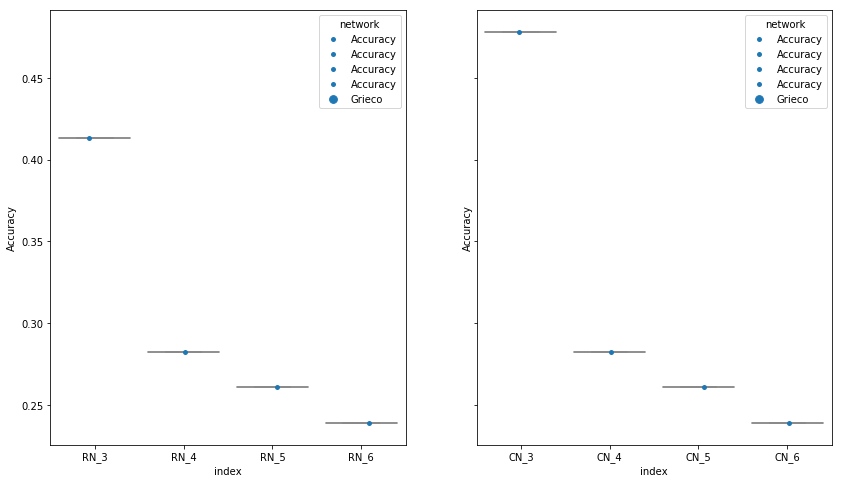

In [10]:
f, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
# plt.figure(figsize=(30,5))
sns.stripplot(x='index', y='Accuracy', data=integrated_c0c1c2_accuracy, hue='network', ax=axes[0])
ax = sns.boxplot(x='index', y='Accuracy', data=integrated_c0c1c2_accuracy,color='.9', ax=axes[0])

sns.stripplot(x='index', y='Accuracy', data=integrated_c3_accuracy, hue='network', ax=axes[1])
ax = sns.boxplot(x='index', y='Accuracy', data=integrated_c3_accuracy,color='.9', ax=axes[1])

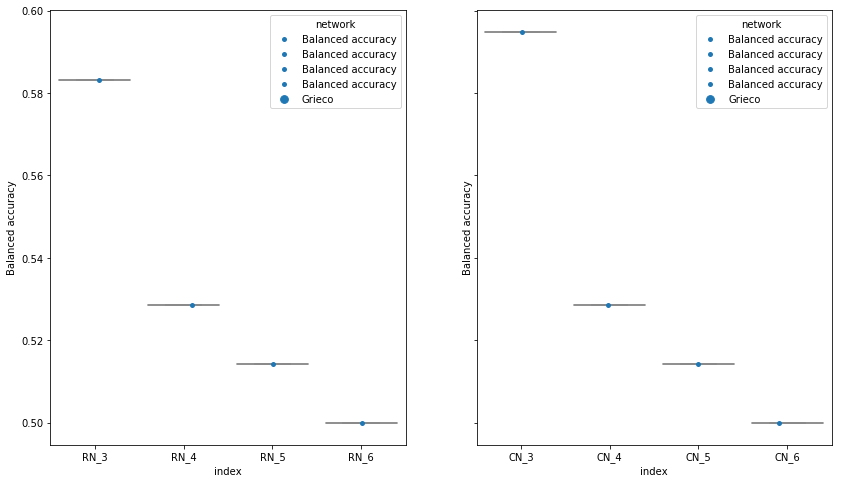

In [11]:
f, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
# plt.figure(figsize=(30,5))
sns.stripplot(x='index', y='Balanced accuracy', data=integrated_c0c1c2_accuracy, hue='network', ax=axes[0] )
ax = sns.boxplot(x='index', y='Balanced accuracy', data=integrated_c0c1c2_accuracy,color='.9', ax=axes[0])

sns.stripplot(x='index', y='Balanced accuracy', data=integrated_c3_accuracy, hue='network', ax=axes[1] )
ax = sns.boxplot(x='index', y='Balanced accuracy', data=integrated_c3_accuracy,color='.9', ax=axes[1])

In [12]:
# scc_num = len(list(nx.strongly_connected_components(GExpanded)))
# print(scc_num)
# scc_size_list = [len(scc) for scc in nx.strongly_connected_components(GExpanded) if len(scc) > 1]
# print(scc_size_list)

In [13]:
# scc_cycle = [len(list(nx.simple_cycles(GExpanded.subgraph(scc)))) for scc in nx.strongly_connected_components(GExpanded) if len(scc) > 1]

# original_cycle = len(list(nx.simple_cycles(GExpanded)))

# result = dict()
# for ex_node in GExpanded.nodes:
#     if '_' not in ex_node:
#         GCopy = GExpanded.copy()
#         neg_ex_node = BDOId.Negation_in_expanded(ex_node)
#         down_composite_neg_ex_node = [x for x in GExpanded.successors(neg_ex_node) if '_' in x]
#         GCopy.remove_node(ex_node)
#         GCopy.remove_node(net_ex_node)
#         GCopy.remove_nodes_from(down_composite_neg_ex_node)
#         result[InverseMapping[ex_node]] = len(list(nx.simple_cycles(GCopy))) / float(original_cycle)

In [14]:
table_expanded_network = pd.read_csv('../data/' + NetworkName + '_table_for_expanded_network.tsv', sep='\t')
for cut_off in CutOffRange:
    inter = 'RN_' + str(cut_off)
    disc = 'CN_' + str(cut_off)
    table_expanded_network[inter] = table_expanded_network['node'].map(lambda x: FFLTest_INTER[x][cut_off])
    table_expanded_network[disc] = table_expanded_network['node'].map(lambda x: FFLTest_DISC[x][cut_off])

In [15]:
cut_off_list = [3, 4, 5, 6]
r0 = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'R0'), dtype=bool)
r1 = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'R1'), dtype=bool)
r2 = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'R2'), dtype=bool)
v = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'V'), dtype=bool)
# real_true = r1
# real_true = np.logical_or(np.array(table_original_network['Class'].map(lambda x: x == 'C0'), dtype=bool), np.array(table_original_network['Class'].map(lambda x: x == 'C1'), dtype=bool))
# accuracy = pd.DataFrame(np.nan, columns=['FFL', 'Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'])
integrated_r0r1r2_accuracy = pd.DataFrame(np.nan, columns=['Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'], index=['RN_'+str(cut_off) for cut_off in cut_off_list])
for cut_off in cut_off_list:
#     ffl = 'FFL_Inter_' + str(cut_off)
    ffl = 'RN_' + str(cut_off)
    positive = np.array(table_expanded_network[ffl], dtype=bool)
#     tp = sum(np.logical_and(real_true, positive))
#     fn = sum(np.logical_and(real_true, np.logical_not(positive)))
#     tn = sum(np.logical_and(np.logical_not(real_true), np.logical_not(positive)))
#     fp = sum(np.logical_and(np.logical_not(real_true), positive))
#     pre = float(tp) / (tp + fp)
#     sen = float(tp) / (tp + fn)
#     spe = float(tn) / (tn + fp)
#     acc = (sen + spe) / 2.

    pre = precision_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
    rec = recall_score(np.logical_or(r0, np.logical_or(r1, r2)), positive) 
    acc = accuracy_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
    bacc = balanced_accuracy_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
    f1 = f1_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
    integrated_r0r1r2_accuracy.loc[ffl]['Precision'] = pre
    integrated_r0r1r2_accuracy.loc[ffl]['Recall'] = rec
    integrated_r0r1r2_accuracy.loc[ffl]['Accuracy'] = acc
    integrated_r0r1r2_accuracy.loc[ffl]['Balanced accuracy'] = bacc
    integrated_r0r1r2_accuracy.loc[ffl]['F1'] = f1
integrated_r0r1r2_accuracy['network'] = NetworkName
integrated_r0r1r2_accuracy.reset_index(inplace=True)

In [16]:
integrated_v_accuracy = pd.DataFrame(np.nan, columns=['Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'], index=['CN_'+str(cut_off) for cut_off in cut_off_list])
for cut_off in cut_off_list:
#     ffl = 'FFL_Inter_' + str(cut_off)
    ffl = 'CN_' + str(cut_off)
    positive = np.array(table_expanded_network[ffl], dtype=bool)
#     tp = sum(np.logical_and(real_true, positive))
#     fn = sum(np.logical_and(real_true, np.logical_not(positive)))
#     tn = sum(np.logical_and(np.logical_not(real_true), np.logical_not(positive)))
#     fp = sum(np.logical_and(np.logical_not(real_true), positive))
#     pre = float(tp) / (tp + fp)
#     sen = float(tp) / (tp + fn)
#     spe = float(tn) / (tn + fp)
#     acc = (sen + spe) / 2.

    pre = precision_score(v, positive)
    rec = recall_score(v, positive) 
    acc = accuracy_score(v, positive)
    bacc = balanced_accuracy_score(v, positive)
    f1 = f1_score(v, positive)
    integrated_v_accuracy.loc[ffl]['Precision'] = pre
    integrated_v_accuracy.loc[ffl]['Recall'] = rec
    integrated_v_accuracy.loc[ffl]['Accuracy'] = acc
    integrated_v_accuracy.loc[ffl]['Balanced accuracy'] = bacc
    integrated_v_accuracy.loc[ffl]['F1'] = f1
integrated_v_accuracy['network'] = NetworkName
integrated_v_accuracy.reset_index(inplace=True)

In [17]:
#load data
# network_name_list= [Grieco, TLGLNetwork, bauer, ERBB, fibroblast, saez, BLT, colitis_jijoo, prostate]
# integrated_data = pd.DataFrame()
networkModel = [jR.bauer(), jR.erbb(), jR.saez(), jR.blt(), jR.colitis_jijoo()]
# networkModel = [jR.grieco()]
for Model in networkModel:
#     Model = jR.grieco()
    BooleanRuleFileName = '../' + Model['BooleanRule_filename']
    network_name = Model['network_name']

    NumInputs = Model['num_inputs']
    NumInputConditions = Model['num_input_conditions']

    InputConditions = Model['input_conditions']

    OutputNodes = Model['output_nodes']
    InputNodes = Model['input_nodes']

    # Set parameters
    # Note the node name for Gread is the index (integer), one can encode the nodename by adding prefix and suffix
    # If the node name from the input file is not this simple, one need to create a dictionary to record the mapping
    Prefix, Suffix = 'n', 'n'

    TempI = jR.initialize(BooleanRuleFileName, Prefix, Suffix)
    Mapping = TempI['mapping']
    InverseMapping = TempI['inverse_mapping']
    GRead = TempI['Gread']
    ReadNodes = TempI['read_nodes']
    if Model['reduction_required']:
        GRead = BDOIp.Get_reduced_network(GRead)
    
    try:
        GExpanded = nx.read_gml('../networks/' + network_name + '_expanded_network.gml')
    except IOError:
        GExpanded = BDOIp.Get_expanded_network(GRead, prefix=Prefix, suffix=Suffix)
        nx.write_gml(GExpanded, '../networks/' + network_name + '_expanded_network.gml')


#     table_original_network = pd.read_csv('../data/' + NetworkName + '_table_for_original_network.tsv', sep='\t').sort_values(by='node')
    GExpanded.remove_edges_from(list(nx.selfloop_edges(GExpanded)))
    table_expanded_network = pd.read_csv('../data/' + network_name + '_table_for_expanded_network.tsv', sep='\t')
    
    cut_off_list = [3, 4, 5, 6]
    FFLTest_INTER = jR.ex_ffl_test_inter(GExpanded, InverseMapping, cut_off_list)
    FFLTest_DISC = jR.ex_ffl_test_disc(GExpanded, InverseMapping, cut_off_list)
    
    r0 = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'R0'), dtype=bool)
    r1 = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'R1'), dtype=bool)
    r2 = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'R2'), dtype=bool)
    v = np.array(table_expanded_network['Class_LDOI'].map(lambda x: x == 'V'), dtype=bool)
    # real_true = r1
    # real_true = np.logical_or(np.array(table_original_network['Class'].map(lambda x: x == 'C0'), dtype=bool), np.array(table_original_network['Class'].map(lambda x: x == 'C1'), dtype=bool))
    # accuracy = pd.DataFrame(np.nan, columns=['FFL', 'Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'])
    
    
    for cut_off in cut_off_list:
        inter = 'RN_' + str(cut_off)
        disc = 'CN_' + str(cut_off)
        table_expanded_network[inter] = table_expanded_network['node'].map(lambda x: FFLTest_INTER[x][cut_off])
        table_expanded_network[disc] = table_expanded_network['node'].map(lambda x: FFLTest_DISC[x][cut_off])
    
    r0r1r2_accuracy = pd.DataFrame(np.nan, columns=['Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'], index=['RN_'+str(cut_off) for cut_off in cut_off_list])
    v_accuracy = pd.DataFrame(np.nan, columns=['Precision', 'Recall', 'Accuracy', 'Balanced accuracy', 'F1'], index=['CN_'+str(cut_off) for cut_off in cut_off_list])
    
    for cut_off in cut_off_list:
    #     ffl = 'FFL_Inter_' + str(cut_off)
        ffl = 'RN_' + str(cut_off)
        positive = np.array(table_expanded_network[ffl], dtype=bool)
    #     tp = sum(np.logical_and(real_true, positive))
    #     fn = sum(np.logical_and(real_true, np.logical_not(positive)))
    #     tn = sum(np.logical_and(np.logical_not(real_true), np.logical_not(positive)))
    #     fp = sum(np.logical_and(np.logical_not(real_true), positive))
    #     pre = float(tp) / (tp + fp)
    #     sen = float(tp) / (tp + fn)
    #     spe = float(tn) / (tn + fp)
    #     acc = (sen + spe) / 2.

        pre = precision_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
        rec = recall_score(np.logical_or(r0, np.logical_or(r1, r2)), positive) 
        acc = accuracy_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
        bacc = balanced_accuracy_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
        f1 = f1_score(np.logical_or(r0, np.logical_or(r1, r2)), positive)
        
        r0r1r2_accuracy.loc[ffl]['Precision'] = pre
        r0r1r2_accuracy.loc[ffl]['Recall'] = rec
        r0r1r2_accuracy.loc[ffl]['Accuracy'] = acc
        r0r1r2_accuracy.loc[ffl]['Balanced accuracy'] = bacc
        r0r1r2_accuracy.loc[ffl]['F1'] = f1
        
        ffl = 'CN_' + str(cut_off)
        positive = np.array(table_expanded_network[ffl], dtype=bool)
    #     tp = sum(np.logical_and(real_true, positive))
    #     fn = sum(np.logical_and(real_true, np.logical_not(positive)))
    #     tn = sum(np.logical_and(np.logical_not(real_true), np.logical_not(positive)))
    #     fp = sum(np.logical_and(np.logical_not(real_true), positive))
    #     pre = float(tp) / (tp + fp)
    #     sen = float(tp) / (tp + fn)
    #     spe = float(tn) / (tn + fp)
    #     acc = (sen + spe) / 2.

        pre = precision_score(v, positive)
        rec = recall_score(v, positive) 
        acc = accuracy_score(v, positive)
        bacc = balanced_accuracy_score(v, positive)
        f1 = f1_score(v, positive)
        v_accuracy.loc[ffl]['Precision'] = pre
        v_accuracy.loc[ffl]['Recall'] = rec
        v_accuracy.loc[ffl]['Accuracy'] = acc
        v_accuracy.loc[ffl]['Balanced accuracy'] = bacc
        v_accuracy.loc[ffl]['F1'] = f1
        
        
    r0r1r2_accuracy['network'] = network_name
    r0r1r2_accuracy.reset_index(inplace=True)
    v_accuracy['network'] = network_name
    v_accuracy.reset_index(inplace=True)
    integrated_r0r1r2_accuracy = pd.concat([integrated_r0r1r2_accuracy, r0r1r2_accuracy], ignore_index=True)
    integrated_v_accuracy = pd.concat([integrated_v_accuracy, v_accuracy], ignore_index=True)    

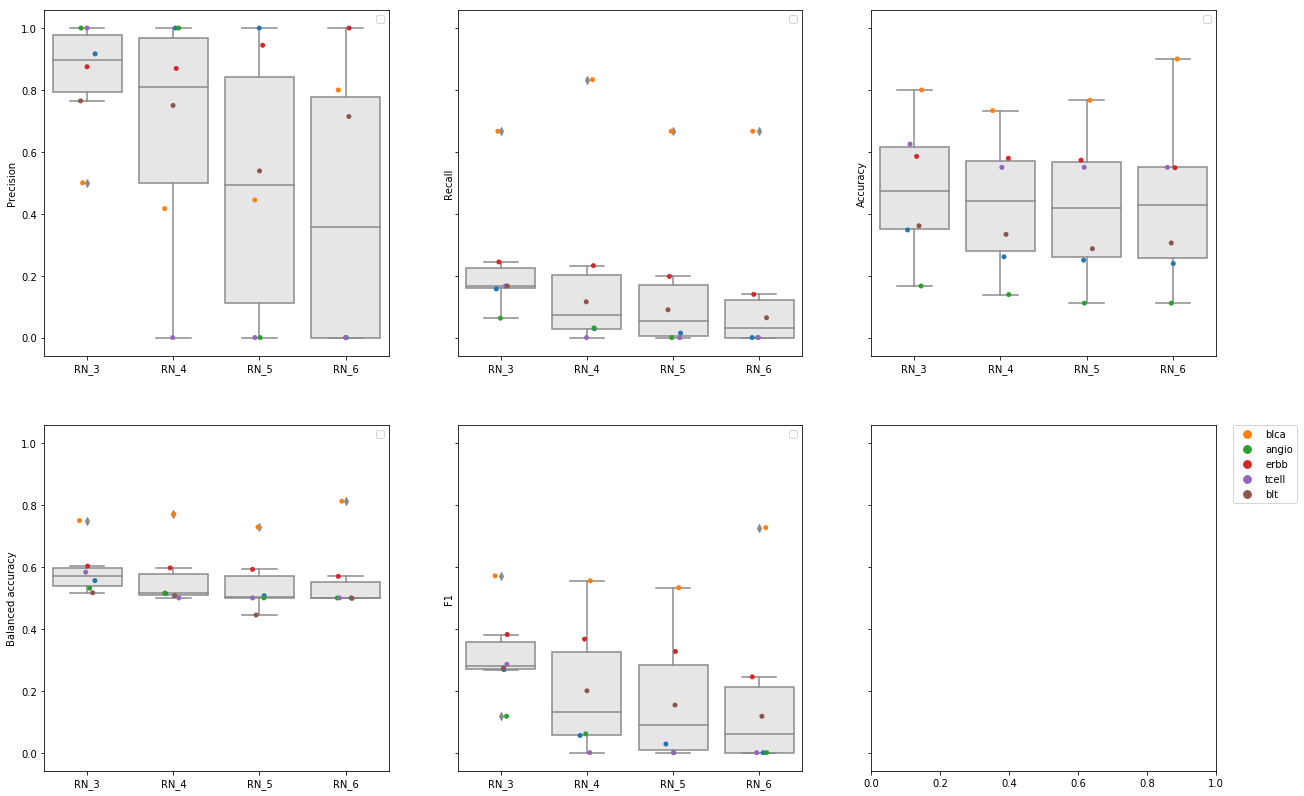

In [20]:
f, axes = plt.subplots(2, 3, figsize=(21, 14), sharey=True)
# plt.figure(figsize=(30,5))
sns.stripplot(x='index', y='Precision', data=integrated_r0r1r2_accuracy, hue='network', ax=axes[0,0])
ax = sns.boxplot(x='index', y='Precision', data=integrated_r0r1r2_accuracy,color='.9', ax=axes[0,0])

sns.stripplot(x='index', y='Recall', data=integrated_r0r1r2_accuracy, hue='network', ax=axes[0,1])
ax = sns.boxplot(x='index', y='Recall', data=integrated_r0r1r2_accuracy,color='.9', ax=axes[0,1])

sns.stripplot(x='index', y='Accuracy', data=integrated_r0r1r2_accuracy, hue='network', ax=axes[0,2])
ax = sns.boxplot(x='index', y='Accuracy', data=integrated_r0r1r2_accuracy,color='.9', ax=axes[0,2])

sns.stripplot(x='index', y='Balanced accuracy', data=integrated_r0r1r2_accuracy, hue='network', ax=axes[1,0])
ax = sns.boxplot(x='index', y='Balanced accuracy', data=integrated_r0r1r2_accuracy,color='.9', ax=axes[1,0])

sns.stripplot(x='index', y='F1', data=integrated_r0r1r2_accuracy, hue='network', ax=axes[1,1])
ax = sns.boxplot(x='index', y='F1', data=integrated_r0r1r2_accuracy,color='.9', ax=axes[1,1])

handles, labels = ax.get_legend_handles_labels()
axes[0,0].legend(handles[:0], labels[:0])
axes[0,1].legend(handles[:0], labels[:0])
axes[0,2].legend(handles[:0], labels[:0])
axes[1,0].legend(handles[:0], labels[:0])
axes[1,1].legend(handles[:0], labels[:0])

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,2].set_xlabel('')
axes[1,0].set_xlabel('')
axes[1,1].set_xlabel('')
axes[1,2].set_xlabel('')

l = plt.legend(handles[5:], ['blca', 'angio', 'erbb', 'tcell', 'blt', 'coad'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

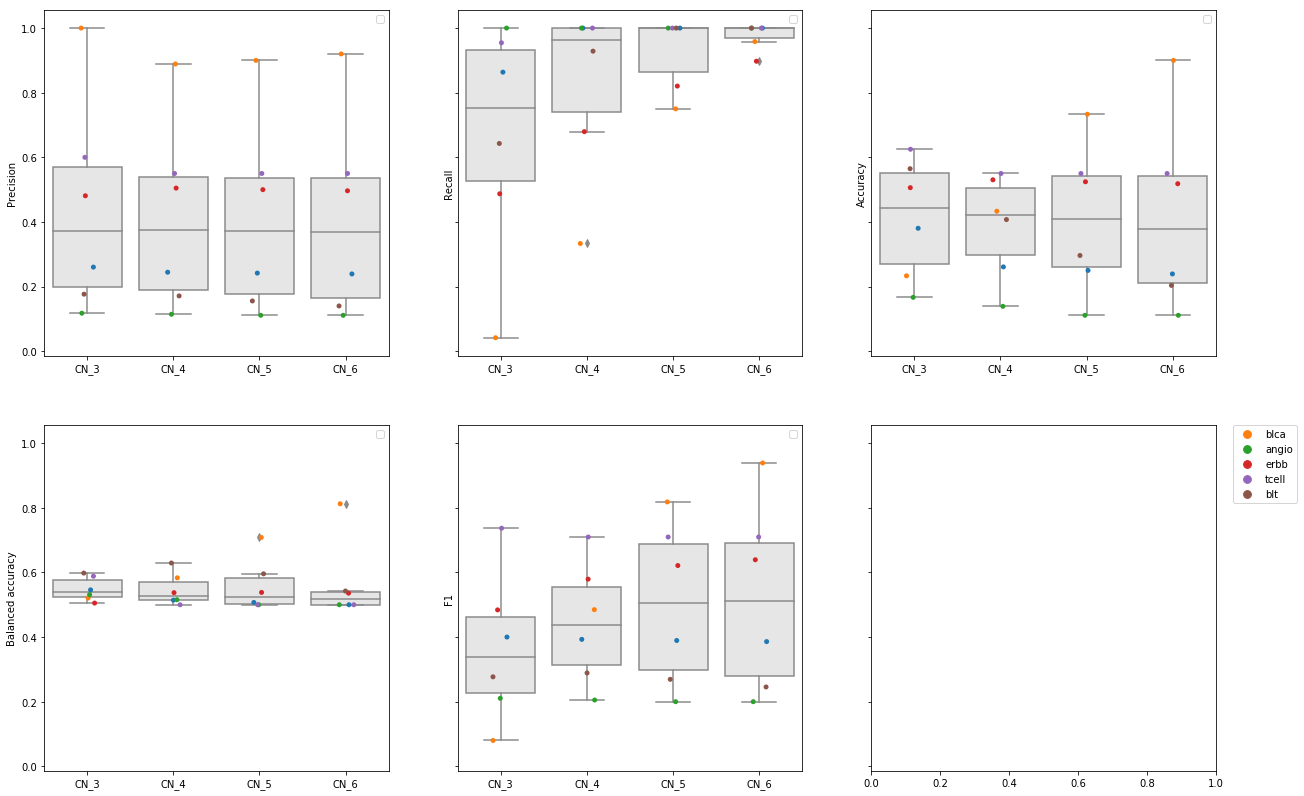

In [21]:
f, axes = plt.subplots(2, 3, figsize=(21, 14), sharey=True)
# plt.figure(figsize=(30,5))
sns.stripplot(x='index', y='Precision', data=integrated_v_accuracy, hue='network', ax=axes[0,0])
ax = sns.boxplot(x='index', y='Precision', data=integrated_v_accuracy,color='.9', ax=axes[0,0])

sns.stripplot(x='index', y='Recall', data=integrated_v_accuracy, hue='network', ax=axes[0,1])
ax = sns.boxplot(x='index', y='Recall', data=integrated_v_accuracy,color='.9', ax=axes[0,1])

sns.stripplot(x='index', y='Accuracy', data=integrated_v_accuracy, hue='network', ax=axes[0,2])
ax = sns.boxplot(x='index', y='Accuracy', data=integrated_v_accuracy,color='.9', ax=axes[0,2])

sns.stripplot(x='index', y='Balanced accuracy', data=integrated_v_accuracy, hue='network', ax=axes[1,0])
ax = sns.boxplot(x='index', y='Balanced accuracy', data=integrated_v_accuracy,color='.9', ax=axes[1,0])

sns.stripplot(x='index', y='F1', data=integrated_v_accuracy, hue='network', ax=axes[1,1])
ax = sns.boxplot(x='index', y='F1', data=integrated_v_accuracy,color='.9', ax=axes[1,1])

handles, labels = ax.get_legend_handles_labels()
axes[0,0].legend(handles[:0], labels[:0])
axes[0,1].legend(handles[:0], labels[:0])
axes[0,2].legend(handles[:0], labels[:0])
axes[1,0].legend(handles[:0], labels[:0])
axes[1,1].legend(handles[:0], labels[:0])

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,2].set_xlabel('')
axes[1,0].set_xlabel('')
axes[1,1].set_xlabel('')
axes[1,2].set_xlabel('')

l = plt.legend(handles[5:], ['blca', 'angio', 'erbb', 'tcell', 'blt', 'coad'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)